# packages 

In [1]:
import numpy as np
import pandas as pd
import xarray
import funcs as f
import os

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
fs=14
plt.rc("font",size=fs)

### parameters

In [3]:
spacings = {"mynn":333, "ysu":333, "sh":333, "vles":333, "LES":25, "LES_raw":25}

In [4]:
colors = { "LES"   :"k",
          "LES_raw":"k",
          "vles"   :"#808B96",
          "mynn"   :"#641E16",
          "ysu"    :"#A93226",
          "sh"     :"#D98880",}

lss =    { "LES"   :"-",
          "LES_raw":"-",
          "vles"   :"-",
          "mynn"   :"-",
          "ysu"    :"-",
          "sh"     :"-",}

lws =    { "LES"   :2,
          "LES_raw":4,
          "vles"   :2,
          "mynn"   :2,
          "ysu"    :2,
          "sh"     :2}

In [5]:
keys_in_order = ['LES_raw', 'LES', 'vles', 'mynn', 'ysu', 'sh']
sims          = ["LES","vles","mynn","ysu","sh"]
datapath      = "/Volumes/Baby-Orange/XPIA-NCAR/rawest/"
outpath       = "/Volumes/Baby-Orange/XPIA-NCAR/processed/"

### io

In [6]:
days=[20,21,28,29,30]

for iday,day in enumerate(days):
    path = "/Volumes/Baby-Orange/XPIA-NCAR/processed/PBLH_SPATIAL_AVG_15km_by_15km_D02_March{0}.csv".format(day)
    tmp = pd.read_csv(path, index_col=[0], parse_dates=True)
    tmp = tmp['median'].copy()
    if iday==0:
        df_zi = tmp.copy()
    else:
        df_zi = pd.concat([df_zi,tmp],axis=0)

In [7]:
z_zi_target = 0.5

In [8]:
convective      = pd.read_csv(os.path.join(outpath,"datetimes_ziL_gt_25.csv"),header=None,index_col=[0])
convective_list = np.array([ pd.Timestamp(l[0]) for l in convective.values.tolist() ])
nt              = len(convective_list)
print(nt)

269


### functions

In [9]:
def get_prime_and_means(datapath, datetime, zi, varnames=['ws','w'], z_zi_target=0.5, sims=["LES","vles","mynn","ysu","sh"], verbose=False):
    
    datetime_str = "{0:%Y-%m-%d_%H:%M}".format(datetime)
    
    xy_primes    = {}
    xy_means     = {}        

    for sim in sims:        

        xy_primes[sim] = {}
        xy_means[sim]  = {}
        if sim.lower()=="les":
            xy_primes[sim+"_raw"] = {}
            xy_means[sim+"_raw"]  = {}          

        sim_prefix      = sim+"_25m" if sim.lower()=="les" else sim
        fpath           = os.path.join(datapath,"WRF_{0}_3D_{1}_plus_filtered.nc".format(sim_prefix,datetime_str))    
        data            = xarray.open_dataset(fpath)

        if 'ws' in varnames:
            data["ws_filt"] = np.sqrt(data["u_filt"]**2+data["v_filt"]**2)
            data["ws"]      = np.sqrt(data["u"]**2+data["v"]**2)    
                
        z         = data['z'].copy()
        zmean     = np.median(z.values,axis=(1,2))
        z_zi      = zmean/zi    
        k         = np.argmin(np.abs(z_zi-z_zi_target))    
        
        if verbose:
            print("................")            
            print("Simulation : {0}".format(sim))
            print("File : {0}".format(os.path.split(fpath)[-1]))
            print("Vertical level : {0}".format(k))         
        
        for varname in varnames:                
            variable  = data[varname+"_filt"].copy()
            xy_mean   = np.mean(variable.values,axis=(1,2))
            xy_prime  = variable.values - xy_mean[:,np.newaxis,np.newaxis]

            xy_primes[sim][varname] = xy_prime[k,...].copy()
            xy_means[sim][varname]  = xy_mean.copy()

            if verbose:
                print("Getting {0}".format(varname+"_filt"))

            # sim == "LES" also get the raw values, i.e. without the primes
            if sim.lower()=="les":              
                if verbose:            
                    print("Getting {0}".format(varname))        
                variable              = data[varname].copy()
                xy_mean               = np.mean(variable.values,axis=(1,2))
                xy_prime              = variable.values - xy_mean[:,np.newaxis,np.newaxis]
                xy_primes[sim+"_raw"][varname] = xy_prime[k,...].copy()    
                xy_means[sim+"_raw"][varname]  = xy_mean.copy()

    return xy_primes, xy_means

### bulk

In [11]:
plot_cartesian_csd = False
plot_polar_csd     = False
plot_azimuthal_csd = False
save               = True

varnames = ['w','theta']
varname = "theta_w"

year    = 2015
month   = 3
days    = [20,21,28,29,30]
hours   = np.arange(14,24,1)
minutes = np.arange(0,60,10)

for day in days:
    for hour in hours:
        for minute in minutes:

            datetime     = pd.Timestamp(year=year,month=month,day=day,hour=hour,minute=minute)        
            zi           = df_zi.loc[datetime]

            xy_primes, xy_means = get_prime_and_means(datapath, datetime, zi, varnames=varnames, verbose=True)

            f1d    = {}
            csd_2d = {}

            # power and power density in cartesian grid
            for key in xy_primes.keys():
                print("................")    
                print("Simulation : {0}".format(key))

                arrays  = xy_primes
                spacing = spacings[key]
                print("Spacing : {0}".format(spacing))

                f1d[key], csd_2d[key] = f.get_csd_2d(array1=arrays[key][varnames[0]], array2=arrays[key][varnames[1]], spacing=spacing)

            if plot_cartesian_csd:
                for key in xy_primes.keys():   
                    fig = f.plot_psd_cartesian(f1d[key],np.abs(csd_2d[key]),log10=True)
                    fig.suptitle(key)

            # power and power density in polar grid
            x         = {}
            y         = {}
            theta     = {}
            r         = {}
            csd_polar = {}

            for key in csd_2d.keys():
                x[key], y[key], theta[key], r[key], csd_polar[key] = f.psd_cartesian_to_polar(f1d[key],csd_2d[key])

            if plot_polar_csd:
                for key in xy_primes.keys():
                    fig = f.plot_psd_polar(theta[key],r[key],np.abs(csd_polar[key]),log10=True)#,vmin=-5,vmax=7)  
                    fig.suptitle(key)

            # power and power density averaged azimuthally
            r_1d   = {}    
            csd_1d = {}

            for key in csd_2d.keys():
                csd_1d[key]   = np.nanmean(csd_polar[key],1)
                r_1d[key]     = np.nanmean(r[key],1)    

            if plot_azimuthal_csd:

                fig = plt.figure(figsize=(6,6))
                ax  = fig.add_subplot(111)
                ax.grid(color='gray', linestyle=':', linewidth=1)

                for key in keys_in_order:
                    ax.semilogx(r_1d[key],csd_1d[key],lw=3,label=key.upper(),color=colors[key], linestyle=lss[key], linewidth=lws[key])

                ax.set_xlabel("Wave number $\kappa=\sqrt{\kappa_x^2+\kappa_y^2}$ [1/m]")
                ax.set_ylabel("Azimuthally averaged, two-dimensional\nCospectrum [m$^2$/s$^2$]")
                ax.set_title("$z/z_i={0}$".format(z_zi_target)+"\n$t=${0:%Y-%m-%d %H:%M} UTC".format(datetime)+"\nvariable: {0}".format(varname))
                plt.legend()

            if save:
                fout = os.path.join(outpath,"csd_cartesian_{0:%Y-%m-%d_%H-%M}_{1}.npz".format(datetime,varname))
                print("===> {0}".format(fout))
                np.savez_compressed(fout, frequency_fine=f1d["LES"], frequency_coarse=f1d["mynn"], mynn=csd_2d['mynn'], ysu=csd_2d['ysu'], vles=csd_2d['vles'], sh=csd_2d['sh'], les=csd_2d['LES'], les_raw=csd_2d['LES_raw'])

                fout = os.path.join(outpath,"csd_polar_{0:%Y-%m-%d_%H-%M}_{1}.npz".format(datetime,varname))
                print("===> {0}".format(fout))   
                np.savez_compressed(fout, radii_coarse=r["sh"], radii_fine=r["LES"], thetas=theta[key], x_coarse=x["sh"], x_fine=x["LES"], y_coarse=y["sh"], y_fine=y["LES"], mynn=csd_polar['mynn'], ysu=csd_polar['ysu'], vles=csd_polar['vles'], sh=csd_polar['sh'], les=csd_polar['LES'], les_raw=csd_polar['LES_raw'])

                df = pd.DataFrame(index=r_1d["sh"],columns=["sh","mynn","vles","ysu"])
                for key in df.columns:
                    df[key] = csd_1d[key].copy()
                df.columns = [a.lower() for a in df.columns]    
                fout = os.path.join(outpath,"csd_azimuthal_mean_gray_zone_{0:%Y-%m-%d_%H-%M}_{1}.npz".format(datetime,varname))
                print("===> {0}".format(fout))               
                df.to_csv(fout)
                
                df = pd.DataFrame(index=r_1d["LES"],columns=["LES","LES_raw"])
                for key in df.columns:
                    df[key] = csd_1d[key].copy()
                df.columns = [a.lower() for a in df.columns]    
                fout = os.path.join(outpath,"csd_azimuthal_mean_les_{0:%Y-%m-%d_%H-%M}_{1}.npz".format(datetime,varname))
                print("===> {0}".format(fout))               
                df.to_csv(fout)                                  

................
Simulation : LES
File : WRF_LES_25m_3D_2015-03-20_14:00_plus_filtered.nc
Vertical level : 8
Getting w_filt
Getting w
Getting theta_filt
Getting theta
................
Simulation : vles
File : WRF_vles_3D_2015-03-20_14:00_plus_filtered.nc
Vertical level : 8
Getting w_filt
Getting theta_filt
................
Simulation : mynn
File : WRF_mynn_3D_2015-03-20_14:00_plus_filtered.nc
Vertical level : 8
Getting w_filt
Getting theta_filt
................
Simulation : ysu
File : WRF_ysu_3D_2015-03-20_14:00_plus_filtered.nc
Vertical level : 8
Getting w_filt
Getting theta_filt
................
Simulation : sh
File : WRF_sh_3D_2015-03-20_14:00_plus_filtered.nc
Vertical level : 8
Getting w_filt
Getting theta_filt
................
Simulation : LES
Spacing : 25


/Users/pdoubraw/anaconda3/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


scaling factor: 3.1640625e-05
................
Simulation : LES_raw
Spacing : 25
scaling factor: 3.1640625e-05
................
Simulation : vles
Spacing : 333
scaling factor: 1
................
Simulation : mynn
Spacing : 333
scaling factor: 1
................
Simulation : ysu
Spacing : 333
scaling factor: 1
................
Simulation : sh
Spacing : 333
scaling factor: 1
===> /Volumes/Baby-Orange/XPIA-NCAR/processed/csd_cartesian_2015-03-20_14-00_theta_w.npz
===> /Volumes/Baby-Orange/XPIA-NCAR/processed/csd_polar_2015-03-20_14-00_theta_w.npz
===> /Volumes/Baby-Orange/XPIA-NCAR/processed/csd_azimuthal_mean_gray_zone_2015-03-20_14-00_theta_w.npz
===> /Volumes/Baby-Orange/XPIA-NCAR/processed/csd_azimuthal_mean_les_2015-03-20_14-00_theta_w.npz
................
Simulation : LES
File : WRF_LES_25m_3D_2015-03-20_14:10_plus_filtered.nc
Vertical level : 12
Getting w_filt
Getting w
Getting theta_filt
Getting theta
................
Simulation : vles
File : WRF_vles_3D_2015-03-20_14:10_plus_filt

# DEBUG

In [41]:
from scipy import fftpack

def get_csd_2d(array1, array2, spacing):

    (npts,npts) = array1.shape

    # apply window (to minimize noise since the arrays are not periodic in space)
    hamm_2d = f.return_hamming(Nx=npts,Ny=npts)    
    array1_windowed = array1 * hamm_2d
    array2_windowed = array2 * hamm_2d    

    # apply fft
    fftarray1  = fftpack.fft2(array1_windowed)
    fftarray2  = fftpack.fft2(array2_windowed)    

    # get csd
    csd_2d   = fftarray1 * fftarray2
    csd_2d   = np.abs(csd_2d)
    
    # scale the csd when needed
    factor = (90/1200)**4 if npts==1200 else 1
    print("scaling factor: {0}".format(factor))
    csd_2d = csd_2d*factor    
    
    # shift
    csd_2d = fftpack.fftshift(csd_2d)    
    
    # get frequencies
    frequency = fftpack.fftfreq(npts, d=spacing)
    frequency = fftpack.fftshift(frequency)    
    
    return frequency, csd_2d

In [42]:
# power and power density in cartesian grid
for key in xy_primes.keys():
    print("................")    
    print("Simulation : {0}".format(key))

    arrays  = xy_primes
    spacing = spacings[key]
    print("Spacing : {0}".format(spacing))

    f1d[key], csd_2d[key] = get_csd_2d(array1=arrays[key]['w'], array2=arrays[key]['ws'], spacing=spacing)

................
Simulation : LES
Spacing : 25
scaling factor: 3.1640625e-05
................
Simulation : LES_raw
Spacing : 25
scaling factor: 3.1640625e-05
................
Simulation : vles
Spacing : 333
scaling factor: 1
................
Simulation : mynn
Spacing : 333
scaling factor: 1
................
Simulation : ysu
Spacing : 333
scaling factor: 1
................
Simulation : sh
Spacing : 333
scaling factor: 1


(-0.001, 0.001)

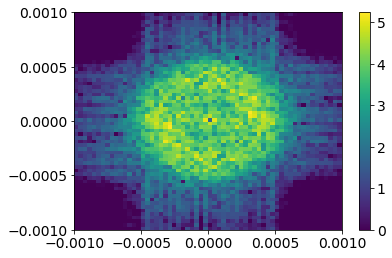

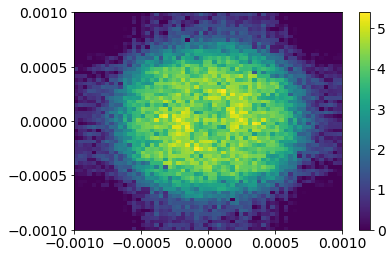

In [43]:
lim=0.001

key="LES"
plt.figure()
plt.pcolormesh(f1d[key],f1d[key],np.log10(csd_2d[key]),vmin=0)
plt.colorbar()
plt.xlim([-lim,lim])
plt.ylim([-lim,lim])

key='mynn'
plt.figure()
plt.pcolormesh(f1d[key],f1d[key],np.log10(csd_2d[key]),vmin=0)
plt.colorbar()
plt.xlim([-lim,lim])
plt.ylim([-lim,lim])

/Users/pdoubraw/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Saw kwargs ['lw', 'linewidth'] which are all aliases for 'linewidth'.  Kept value from 'linewidth'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  


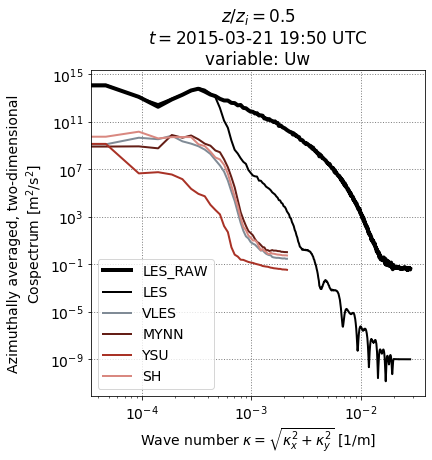

In [11]:
fig = plt.figure(figsize=(6,6))
ax  = fig.add_subplot(111)
ax.grid(color='gray', linestyle=':', linewidth=1)

for key in keys_in_order:
    ax.loglog(r_1d[key],csd_1d[key],lw=3,label=key.upper(),color=colors[key], linestyle=lss[key], linewidth=lws[key])

ax.set_xlabel("Wave number $\kappa=\sqrt{\kappa_x^2+\kappa_y^2}$ [1/m]")
ax.set_ylabel("Azimuthally averaged, two-dimensional\nCospectrum [m$^2$/s$^2$]")
ax.set_title("$z/z_i={0}$".format(z_zi_target)+"\n$t=${0:%Y-%m-%d %H:%M} UTC".format(datetime)+"\nvariable: {0}".format(varname))
plt.legend()

# DEBUG

In [24]:
from scipy import fftpack

In [50]:
# power and power density in cartesian grid
for key in xy_primes.keys():
    print("................")    
    print("Simulation : {0}".format(key))

    arrays  = xy_primes
    spacing = spacings[key]
    print("Spacing : {0}".format(spacing))

    f1d[key], csd_2d[key] = get_csd_2d(array1=arrays[key]['w'], array2=arrays[key]['ws'], spacing=spacing)

................
Simulation : LES
Spacing : 25
................
Simulation : LES_raw
Spacing : 25
................
Simulation : vles
Spacing : 333
................
Simulation : mynn
Spacing : 333
................
Simulation : ysu
Spacing : 333
................
Simulation : sh
Spacing : 333


In [54]:
filterf = 1/(333.*2)

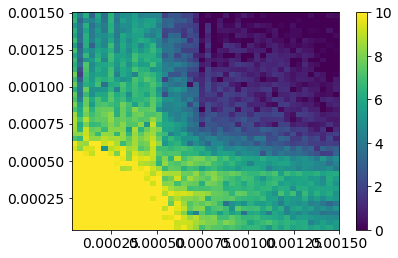

In [56]:
key="LES"
plt.pcolormesh(f1d[key],f1d[key],np.log10(csd_2d[key]),vmin=0,vmax=10)
plt.xlim([minf,filterf])
plt.ylim([minf,filterf])
plt.colorbar()

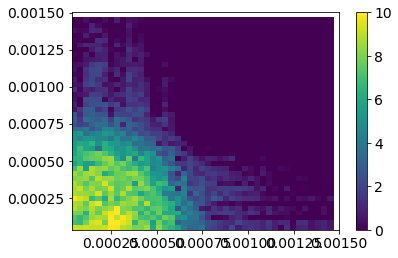

In [55]:
key="sh"
plt.pcolormesh(f1d[key],f1d[key],np.log10(csd_2d[key]),vmin=0,vmax=10)
plt.xlim([minf,filterf])
plt.ylim([minf,filterf])
plt.colorbar()

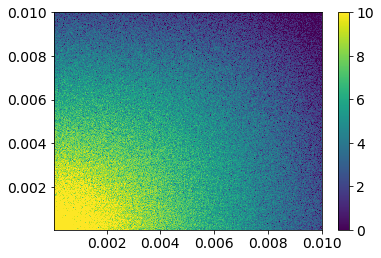

In [52]:
key="LES_raw"
plt.pcolormesh(f1d[key],f1d[key],np.log10(csd_2d[key]),vmin=0,vmax=10)
plt.xlim([minf,filterf])
plt.ylim([minf,filterf])
plt.colorbar()

# JUNKYARD

In [15]:
minf    = 1/30000.
maxf    = 1/333.
filterf = 1/(50.*2)

/Users/pdoubraw/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Saw kwargs ['lw', 'linewidth'] which are all aliases for 'linewidth'.  Kept value from 'linewidth'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  


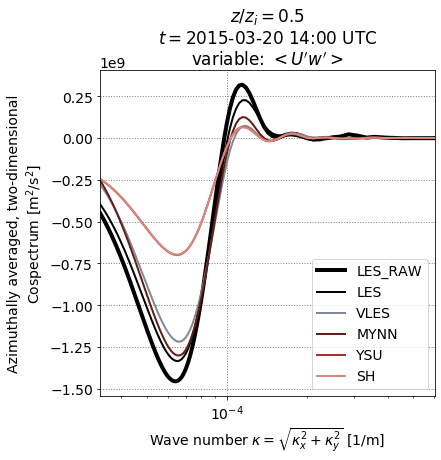

In [83]:
            fig = plt.figure(figsize=(6,6))
            ax  = fig.add_subplot(111)
            ax.grid(color='gray', linestyle=':', linewidth=1)

            for key in keys_in_order:
                ax.semilogx(r_1d[key],csd_1d[key],lw=3,label=key.upper(),color=colors[key], linestyle=lss[key], linewidth=lws[key])

            ax.set_xlabel("Wave number $\kappa=\sqrt{\kappa_x^2+\kappa_y^2}$ [1/m]")
            ax.set_ylabel("Azimuthally averaged, two-dimensional\nCospectrum [m$^2$/s$^2$]")
            ax.set_title("$z/z_i={0}$".format(z_zi_target)+"\n$t=${0:%Y-%m-%d %H:%M} UTC".format(datetime)+"\nvariable: {0}".format("$<U'w'>$"))
            ax.set_xlim([minf,filterf])
            plt.legend()

# open saved files to make sure they are ok

In [15]:

year     = 2015
month    = 3
day      = 20
hour     = 14
minute   = 0
varname  = 'w'
datetime = pd.Timestamp(year=year,month=month,day=day,hour=hour,minute=minute)
    
# save everything for this time THIS WONT WORK IF ALL SIMS ARE NOT ON THE SAME GRID, NOT ROBUST ENOUGH
fout = os.path.join(outpath,"psd_cartesian_{0:%Y-%m-%d_%H-%M}_{1}.npz".format(datetime,varname))
print("===> {0}".format(fout))
cartesian = np.load(fout)

fout = os.path.join(outpath,"psd_polar_{0:%Y-%m-%d_%H-%M}_{1}.npz".format(datetime,varname))
print("===> {0}".format(fout))   
polar = np.load(fout)

fout = os.path.join(outpath,"psd_azimuthal_mean_{0:%Y-%m-%d_%H-%M}_{1}.npz".format(datetime,varname))
print("===> {0}".format(fout))       
df = pd.read_csv(fout, index_col=[0])

===> /Volumes/Baby-Orange/XPIA-NCAR/processed/psd_cartesian_2015-03-20_14-00_w.npz
===> /Volumes/Baby-Orange/XPIA-NCAR/processed/psd_polar_2015-03-20_14-00_w.npz
===> /Volumes/Baby-Orange/XPIA-NCAR/processed/psd_azimuthal_mean_2015-03-20_14-00_w.npz


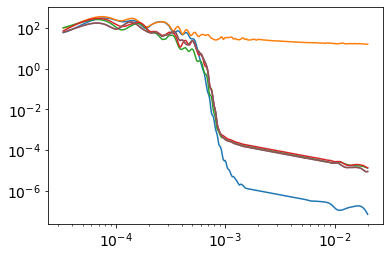

In [18]:
for col in df.columns:
    plt.loglog(df.index, df[col])

### figures (optional)

#### ==> flow field contours

In [37]:
keys_in_order = ["LES_raw","LES","vles","mynn","ysu","sh"]
varname = 'ws'

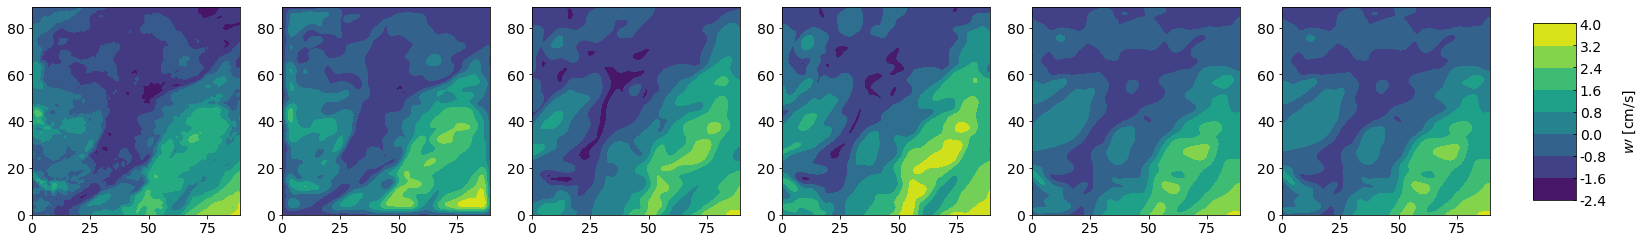

In [38]:

fig = plt.figure(figsize=(6*5,5))
axs = {}

for iax,sim in enumerate(keys_in_order):
    axs[iax] = fig.add_subplot(1,6,iax+1,aspect="equal")
    
    p = axs[iax].contourf(xy_primes_coarse[sim][varname])#, levels=np.arange(-4,4.1,0.2), cmap='magma')
    #variance = np.var(arrays[sim])
    #axs[iax].set_title(sim+"\n $variance={0:.3f}$ m$^2$/s$^2$".format(variance))
    #plt.colorbar(p)
    
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.82, 0.255, 0.02, 0.49])
clb = fig.colorbar(p, cax=cbar_ax, format=FormatStrFormatter('%3.1f'))
clb.set_label('$w\prime$ [cm/s]', labelpad=15, y=0.45)
clb.ax.tick_params(direction='in')     